# Analytic Results - Stationary States

We adopt the 2-population LotkaVolterra model introduced by Strobl et
al.:

$$\frac{dS}{dt} = r_{S} S \left(1 - \frac{S+R}{K}\right) \times (1-d_{D}D) - d_{S}S$$
$$\frac{dR}{dt} = r_{R} R \left(1 - \frac{S+R}{K}\right) - d_{R}R.$$

Both species follow a modified logistic growth model with growth rates
*r*<sub>*S*</sub> and *r*<sub>*R*</sub>, where the total population
(rather than the species population) is modified by the shared carrying
capacity *K*.

In [2]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ffmpeg

from argparse import Namespace
from IPython.display import display, Markdown, Latex, HTML

sys.path.append("../utils")
from myUtils import convert_ode_parameters,  calc_critical_treatment_threshold, calc_critical_treatment_interval, TreatmentListToTS, ExtractTreatmentFromDf
from odeModels import LotkaVolterraModel


In [3]:
# Defaults for plotting
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0)

In [4]:
def CalcDrug(dataDf):
    drugConcentrationItem = TreatmentListToTS(treatmentList=ExtractTreatmentFromDf(dataDf),
                                                    tVec=dataDf['Time'])
    try:
        drugConcentrationVec += drugConcentrationItem
        max_dose = max(max_dose, np.max(drugConcentrationItem))
    except UnboundLocalError:
        drugConcentrationVec = drugConcentrationItem
        max_dose = np.max(drugConcentrationItem)

    return drugConcentrationVec

In [5]:
def PlotDrug(dataDf, ax, color,  currDrugBarPosition = 1.2, drugBarHeight = 0.2, line_max=None, **kwargs):
    # Generate drug data as time series from list

    drugConcentrationVec = CalcDrug(dataDf) * drugBarHeight + currDrugBarPosition
    line_max = dataDf['Time'].max() if line_max is None else line_max
    ax.fill_between(x=dataDf['Time'], y1=currDrugBarPosition, y2=drugConcentrationVec, linewidth=0.0,
                     alpha=0.5, step="post", label="Drug Concentration", color=color, **kwargs)
    ax.hlines(xmin=dataDf['Time'].min(), xmax=line_max, y=currDrugBarPosition, linewidth=3, color="black")
    ax.hlines(xmin=dataDf['Time'].min(), xmax=line_max, y=currDrugBarPosition + drugBarHeight, linewidth=3, color="black")

In [6]:
def Plot_method(df, legend=False, drug_label="Drug Concentration",
         ax=None, linestyle='-', linewidth=5, drug_limit = None, colors = None, **kwargs):
    if ax is None: fig, ax = plt.subplots(1, 1)
    linestyles = [linestyle, '--', '--']
    for i, var in enumerate(["TumourSize", 'S', 'R']):
        ax.plot(df['Time'], df[var], linewidth=linewidth, linestyle=linestyles[i], color=colors[var], **kwargs)

    PlotDrug(df, ax, 'k', line_max=drug_limit, currDrugBarPosition = 1.25)
    ax.hlines(xmin=0, xmax=max(df['Time']), y=1, linestyles=":", linewidth=6, color='grey')
    ax.hlines(xmin=0, xmax=max(df['Time']), y=1.2, linestyles=":", linewidth=6, color='grey')

    # Format the plot
    ax.set_title(kwargs.get('title', ''))
    ax.set_xlim(0, max(df['Time'])); ax.set_ylim(0, 1.4)
    ax.yaxis.get_major_ticks()[-1].set_visible(False); ax.tick_params(right = False, top = False)
    plt.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


        Time         S         R  TumourSize  DrugConcentration
4976  4976.0  0.404854  0.928479    1.333333                1.0
4977  4977.0  0.404854  0.928479    1.333333                1.0
4978  4978.0  0.404854  0.928479    1.333333                1.0
4979  4979.0  0.404854  0.928479    1.333333                1.0
4980  4980.0  0.404854  0.928479    1.333333                1.0
{'n0': 0.75, 'rS': 0.027, 'rR': 0.027, 'dS': 0.0, 'dR': 0.0, 'dD': 1.5, 'K': 1.0, 'D': 0, 'theta': 1, 'DMax': 1.0, 'S0': 0.74925, 'R0': 0.0075}


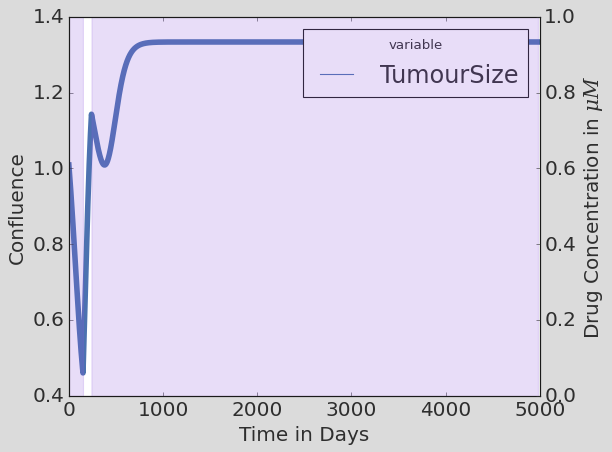

In [7]:
# Modify initial conditions to observe impact on steady state - increase R0 (N0 virtually unchanged)

newParamDic = odeParamDic.copy(); newParamDic['R0'] = 10 * odeParamDic['R0']

at50_model = LotkaVolterraModel(method='RK45')
at50_model.SetParams(**newParamDic)
at50_model.Simulate_AT(atThreshold=0.5, intervalLength=30, tumourSizeWhenProgressed=2, t_end=5000);
at50_model.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic['n0'];
at50_model.Trim(dt=1); at50_model.Plot()

print(at50_model.resultsDf.tail())
print(newParamDic)

        Time         S        R  TumourSize  DrugConcentration
4976  4976.0  0.210843  1.12249    1.333333                1.0
4977  4977.0  0.210843  1.12249    1.333333                1.0
4978  4978.0  0.210843  1.12249    1.333333                1.0
4979  4979.0  0.210843  1.12249    1.333333                1.0
4980  4980.0  0.210843  1.12249    1.333333                1.0
{'n0': 0.75, 'rS': 0.027, 'rR': 0.027, 'dS': 0.0, 'dR': 0.0, 'dD': 1.5, 'K': 1.0, 'D': 0, 'theta': 1, 'DMax': 1.0, 'S0': 0.74925, 'R0': 0.0375}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


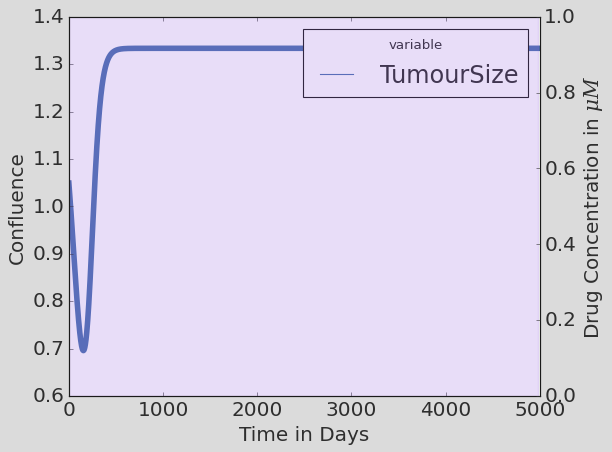

In [8]:
# Modify initial conditions to observe impact on steady state - increase R0 (N0 virtually unchanged)

newParamDic = odeParamDic.copy(); newParamDic['R0'] = 50 * odeParamDic['R0']

at50_model = LotkaVolterraModel(method='RK45')
at50_model.SetParams(**newParamDic)
at50_model.Simulate_AT(atThreshold=0.5, intervalLength=30, tumourSizeWhenProgressed=2, t_end=5000);
at50_model.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic['n0'];
at50_model.Trim(dt=1); at50_model.Plot()

print(at50_model.resultsDf.tail())
print(newParamDic)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


          Time  DrugConcentration         S         R  TumourSize
29996  419.996                1.0  0.083872  1.052975    1.136846
29997  419.997                1.0  0.083871  1.052979    1.136850
29998  419.998                1.0  0.083871  1.052983    1.136854
29999  419.999                1.0  0.083871  1.052987    1.136858
30000  420.000                1.0  0.083871  1.052992    1.136863
{'n0': 0.75, 'rS': 0.027, 'rR': 0.027, 'dS': 0.0, 'dR': 0.0, 'dD': 1.5, 'K': 1.0, 'D': 0, 'theta': 1, 'DMax': 1.0, 'S0': 0.374625, 'R0': 0.00075}


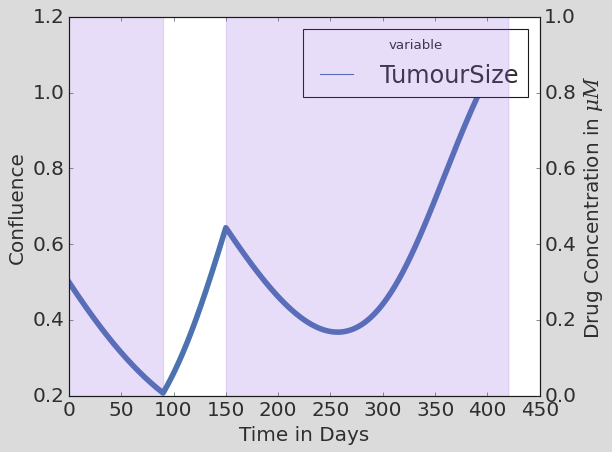

In [9]:
# Modify initial conditions to observe impact on steady state - change S0 and N0

newParamDic = odeParamDic.copy(); newParamDic['S0'] = 0.5 * odeParamDic['S0']

at50_model = LotkaVolterraModel(method='RK45')
at50_model.SetParams(**newParamDic)
at50_model.Simulate_AT(atThreshold=0.5, intervalLength=30, tumourSizeWhenProgressed=2, t_end=5000);
at50_model.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic['n0'];
at50_model.Plot()

print(at50_model.resultsDf.tail())
print(newParamDic)

## Steady state profile for non-zero turnover

In [10]:
def calc_steady_state_nzt(rR, K, dR, **kwargs):
    poly = np.polynomial.polynomial.Polynomial([-dR/rR, 1, -1/K])
    print(poly.roots())

def calc_steady_state(K, rR, dR, **kwargs):
    return (K * (rR - dR)) / rR

def calc_steady_state2(K, rR, dR, **kwargs):
    return (rR * K) / (rR + dR * K)

def calc_steady_state3(K, rR, dR, **kwargs):
    return K / (K * (dR - rR) + 1)

        Time             S         R  TumourSize  DrugConcentration
4976  4976.0  6.083793e-16  1.066667    1.066667                1.0
4977  4977.0  6.034713e-16  1.066667    1.066667                1.0
4978  4978.0  5.986029e-16  1.066667    1.066667                1.0
4979  4979.0  5.937738e-16  1.066667    1.066667                1.0
4980  4980.0  5.889837e-16  1.066667    1.066667                1.0
{'n0': 0.75, 'rS': 0.027, 'rR': 0.027, 'dS': 0.0054, 'dR': 0.0054, 'dD': 1.5, 'K': 1.0, 'D': 0, 'theta': 1, 'DMax': 1.0, 'S0': 0.74925, 'R0': 0.00075}
0.8
0.8333333333333334
1.0220768601798855
[0.2763932 0.7236068]
None


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


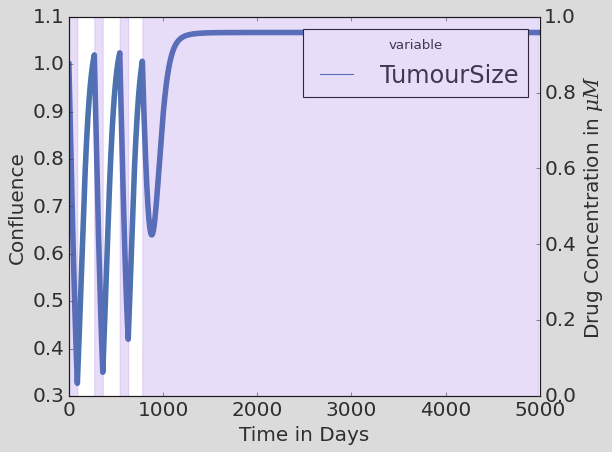

In [11]:
# Modify initial conditions to observe impact on steady state - increase R0 (N0 virtually unchanged)

turnParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0.2)

at50_model = LotkaVolterraModel(method='RK45')
at50_model.SetParams(**turnParamDic)
at50_model.Simulate_AT(atThreshold=0.5, intervalLength=30, tumourSizeWhenProgressed=2, t_end=5000);
at50_model.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic['n0'];
at50_model.Trim(dt=1); at50_model.Plot()

print(at50_model.resultsDf.tail())
print(turnParamDic)
print(calc_steady_state(**turnParamDic))
print(calc_steady_state2(**turnParamDic))
print(calc_steady_state3(**turnParamDic))
print(calc_steady_state_nzt(**turnParamDic))

        Time             S    R  TumourSize  DrugConcentration
4976  4976.0  5.019787e-15  1.0         1.0                1.0
4977  4977.0  4.975932e-15  1.0         1.0                1.0
4978  4978.0  4.932459e-15  1.0         1.0                1.0
4979  4979.0  4.889366e-15  1.0         1.0                1.0
4980  4980.0  4.846649e-15  1.0         1.0                1.0
{'n0': 0.75, 'rS': 0.027, 'rR': 0.0216, 'dS': 0.0054, 'dR': 0.0054, 'dD': 1.5, 'K': 1.0, 'D': 0, 'theta': 1, 'DMax': 1.0, 'S0': 0.74925, 'R0': 0.00075}
0.7499999999999999
0.7999999999999999
1.0164667615368976


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


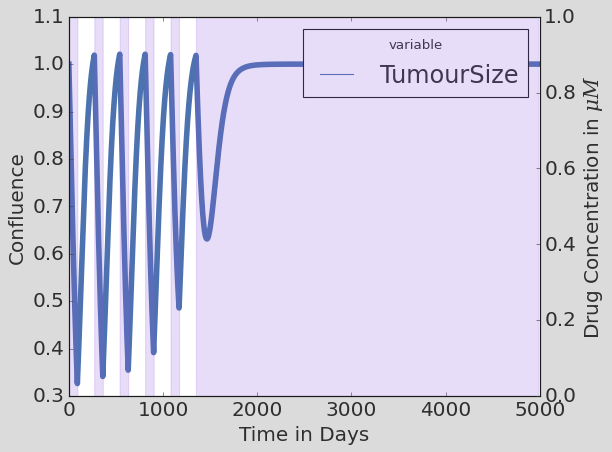

In [12]:
# Modify initial conditions to observe impact on steady state - increase R0 (N0 virtually unchanged)

turnParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0.2, turnover=0.2)

at50_model = LotkaVolterraModel(method='RK45')
at50_model.SetParams(**turnParamDic)
at50_model.Simulate_AT(atThreshold=0.5, intervalLength=30, tumourSizeWhenProgressed=2, t_end=5000);
at50_model.resultsDf[['TumourSize', 'S', 'R']] /= odeParamDic['n0'];
at50_model.Trim(dt=1); at50_model.Plot()

print(at50_model.resultsDf.tail())
print(turnParamDic)
print(calc_steady_state(**turnParamDic))
print(calc_steady_state2(**turnParamDic))
print(calc_steady_state3(**turnParamDic))

A simple summary of these results:

* When turnover is non-zero, we ultimately get a fully resistant tumour under either continuous or adaptive therapy (provided the simulation is not truncated at the progression threshold).

* When turnover is zero, we find a steady state where both sensitive and resistant cell fractions co-exist. This is slightly counter-intuitive, as the resistant cells have no death mechanism, while sensitive cells still die under drug, so we would expect resistant cells to dominate here (even more than they do in non-zero turnover contexts).

* The composition of this steady state is highly dependant on the initial conditions, and this relationship is complex/chaotic; increasing the initial resistant fraction does not increase the steady state resistant fraction monotonically.

* The final size of the steady state is dependant on the initial tumour size (_relationship tbd - could investigate this systematically)_.

## Phase Plane Analysis

$$\frac{dS}{dt} = r_{S} S \left(1 - \frac{S+R}{K}\right) \times (1-d_{D}D) - d_{S}S$$
$$\frac{dR}{dt} = r_{R} R \left(1 - \frac{S+R}{K}\right) - d_{R}R.$$

### Nullclines

Consider separately the states for $\frac{dS}{dt} = 0, \frac{dR}{dt} = 0$. For simplicity we will also let $\delta = (1 - d_{D}D)$, where $D(t)=1$ for constant drug at long timescales.

Considering $\frac{dS}{dt} = 0$, we obtain $ d_{S} = r_{S} \left(1 - \frac{S+R}{K}\right) \delta $, which simplifies to:

$$ R = K \left(1 - \frac{d_{S}}{r_{S}\delta}\right) - S. $$

Similarly for $\frac{dR}{dt} = 0$, we obtain $ d_{R} = r_{R} \left(1 - \frac{S+R}{K}\right) $ which simplifies to:

$$ R = K \left(1 - \frac{d_{R}}{r_{R}}\right) - S. $$

Writing $\eta = \left(1 - \frac{d_{S}}{r_{S}\delta}\right)$ and $\mu = \left(1 - \frac{d_{R}}{r_{R}}\right)$, we obtain the nullclines:

$$R = \eta K - S; \qquad R = \mu K - S$$





# 

In [13]:
def plot_nullclines(ax, ns, colors=['b', 'c'], **kwargs):
    S_space = np.linspace(0, 2)
    ax.plot(S_space, [ns.eta * ns.K - S for S in S_space], linewidth = 6, label = r'$R = \eta K - S$', color=colors[0], **kwargs)
    ax.plot(S_space, [ns.mu * ns.K - S for S in S_space], linewidth = 6, label = r'$R = \mu K - S$', color=colors[1], **kwargs)
    ax.set_xlim(left=0); ax.set_ylim(bottom=0); 
    ax.set_xlabel(r'$S$'); ax.set_ylabel(r'$R$'); ax.legend(scatterpoints=1);

{'n0': 0.75, 'rS': 0.027, 'rR': 0.0216, 'dS': 0.0054, 'dR': 0.0054, 'dD': 1.5, 'K': 1.0, 'D': 0, 'theta': 1, 'DMax': 1.0, 'S0': 0.74925, 'R0': 0.00075}


Line gradients: $\eta K =$ 1.4, $\, \mu K =$ 0.75, for $K = 1$.

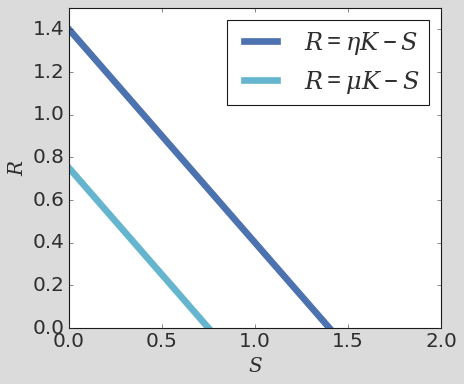

In [14]:
# Set parameter values (P25? We need a basic set) and plot these in phase space

odeParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0.2, turnover=0.2); 
ns = Namespace(**odeParamDic); print(odeParamDic)
ns.delta = 1 - ns.dD; ns.eta = 1 - (ns.dS / (ns.rS * ns.delta)); ns.mu = 1 - (ns.dR / ns.rR)

fig, ax = plt.subplots(1,1,figsize=(6,5))
plot_nullclines(ax, ns)

display(Markdown(f"Line gradients: $\eta K =$ {ns.eta}, $\, \mu K =$ {ns.mu}, for $K = 1$."))

### Stationary States

Trivially, the null state $(S, R) = (0, 0)$ satisfies $\frac{dS}{dt} = 0, \frac{dR}{dt} = 0$ for this system of equations.

For $S=0$, we may write $d_{R}R = \mu r_{R}R $, which results in the stationary state $(0, \mu K)$. Similarly for $R=0$, we find that $d_{s}S = \eta r_{S} S$. 

Finally, assuming $ S, R \neq 0$, we may simplify this system of equations to $S + R = \eta K; S + R = \mu K$. For now we will ignore this state, and will return to the special case where $\eta = \mu$ (and hence this state exists) later.

Therefore, we consider three stationary states:

$$ (S, R) = (0, 0) \quad; \quad (S, R) = (0, \mu K) \quad; \quad (S, R) = (\eta K, 0) $$

N.B Given we are not interested in the null state, we will typically resitrict ourselves to the case where both $\eta$ and $\mu$ are positive. We will see later that negative values in one of these values corresponds to complete exclusion of that species, due to an inherent unfitness in one species, rather that inter-species competition. We will also show that the null state is the only stable state when both $\eta$ and $\mu$ are negative.

In [15]:
def plot_stationary_states(ax, ns):
    ax.scatter([0, 0, ns.eta * ns.K], [0, ns.mu * ns.K, 0], s = 300, zorder=10, marker = 'o', color = 'gray', label = 'Stationary \nStates')
    ax.legend(scatterpoints=1)

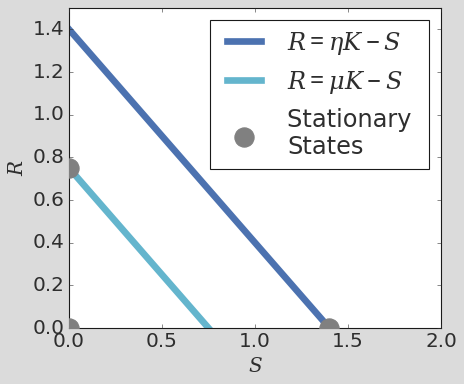

In [16]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plot_nullclines(ax, ns)
plot_stationary_states(ax, ns)

### Stability Analysis

$$\dot{S} = r_{S} S \left(1 - \frac{S+R}{K}\right) \delta - d_{S}S$$
$$\dot{R} = r_{R} R \left(1 - \frac{S+R}{K}\right) - d_{R}R.$$

Despite this being a (second-order) non-linear system, we may still write down a Jacobian of the usual form:

$$ J = \begin{pmatrix} \frac{\partial \dot{S}}{\partial S} & \frac{\partial \dot{S}}{\partial R} \\[0.5em] \frac{\partial \dot{R}}{\partial S} & \frac{\partial \dot{R}}{\partial R} \end{pmatrix}
= \begin{pmatrix} r_{S} \left(1 - \frac{2S+R}{K}\right) \delta - d_{S} & - r_{S} \delta \frac{S}{K} \\[0.5em] - r_{R} \frac{R}{K} & r_{R} \left(1 - \frac{S+2R}{K}\right) - d_{R} \end{pmatrix} $$

To determine the stability of each stationary state, we must compute the Jacobian at the location of each point $(S, R) = (0, 0),\, (0, \mu K),\, (\eta K, 0)$:

#### $(S, R) = (0, 0)$

$$ J = \begin{pmatrix} r_{S} \delta - d_{S} & 0 \\[0.5em] 0 & r_{R} - d_{R} \end{pmatrix} \implies \lambda = r_{S} \delta - d_{S},\, r_{R} - d_{R} $$

This point is only stable if both eigenvalues $\lambda$ are negative. This corresponds to negative $\eta$ and $\mu$, which we interpret as fundamentally unfit species; otherwise this state is always unstable.


#### $(S, R) = (0, \mu K)$

$$ J = \begin{pmatrix} r_{S} \left(1 - \mu \right) \delta - d_{S} & 0 \\[0.5em] - r_{R} \mu & r_{R} \left(1 - 2\mu \right) - d_{R} \end{pmatrix}  \implies \lambda = r_{S} \left(1 - \mu \right) \delta - d_{S},\, r_{R} \left(1 - 2\mu \right) - d_{R} = r_{S} \delta \frac{ d_{R}}{r_{R}} - d_{S},\, d_{R} - r_{R} $$

Note the negative eigenvalue from the null state above, and the additional factor of $1-\eta = \frac{ d_{R}}{r_{R}}$ in the other.  The second eigenvalue is therefore always negative in all non-null states (equivalent to requiring that $\mu > 0$). With some re-arrangement, we find that the first eigenvalue is only negative when $\eta<\mu$, therefore this resistant-only state is only stable in that condition.

#### $(S, R) = (\eta K, 0)$

$$ J = \begin{pmatrix} r_{S} \left(1 - 2\eta \right) \delta - d_{S} & - r_{S} \delta \eta \\[0.5em] 0 & r_{R} \left(1 - \eta\right) - d_{R} \end{pmatrix} \implies \lambda  = r_{S} \left(1 - 2\eta \right) \delta - d_{S} ,\, r_{R} \left(1 - \eta\right) - d_{R} = d_{S} - r_{S} \delta  ,\, r_{R} \frac{d_{S}}{r_{S}\delta} - d_{R}$$

Note the negative eigenvalue from the null state above, and the additional factor of $1-\mu = \frac{d_{S}}{r_{S}\delta}$ in the other. The first eigenvalue is therefore always negative in all non-null states (equivalent to requiring that $\eta > 0$). With some re-arrangement, we find that the second eigenvalue is only negative when $\eta>\mu$, therefore this sensitive-only state is only stable in that condition.

#### $S + R = \eta K = \mu K$


$$ J = \begin{pmatrix} \frac{\partial \dot{S}}{\partial S} & \frac{\partial \dot{S}}{\partial R} \\[0.5em] \frac{\partial \dot{R}}{\partial S} & \frac{\partial \dot{R}}{\partial R} \end{pmatrix}
= \begin{pmatrix} r_{S} \left(1 - \eta - \frac{S}{K}\right) \delta - d_{S} & - r_{S} \delta \frac{S}{K} \\[0.5em] - r_{R} \frac{R}{K} & r_{R} \left(1 - \eta - \frac{R}{K}\right) - d_{R} \end{pmatrix} $$

Rewriting with only resistant parameters, using $\frac{d_{S}}{r_{S}\delta} = \frac{d_{R}}{r_{R}}$ :

$$ J = \begin{pmatrix} r_{S} \left(1 - 2\eta - \frac{R}{K}\right) \delta - d_{S} & - r_{S} \delta \frac{S}{K} \\[0.5em] - r_{R} \frac{R}{K} & r_{R} \left(1 - \eta - \frac{R}{K}\right) - d_{R} \end{pmatrix} $$

This is not easily tractable, however if we focus on the zero-turnover case (wherein $S + R = K$), we obtain interpretable eigenvalues:

$$ \lambda = 0, -\frac{r_{R}R + \delta r_{S}S}{R+S} $$

This second value is always negative (provided $\delta < 0$), while the zero eigenvalue allows stable oscillations within this state - this eigenvalue corresponds to the eigenvector $(-1, 1)$.




### Relative magnitudes of $\eta$ and $\mu$

As mentioned previously, both the number of stationary states and their character depend on the relative magnitude of constants $\eta$ and $\mu$ (repeated below for clarity):

$$\eta = \left(1 - \frac{d_{S}}{r_{S}\delta}\right) \quad ; \quad \mu = \left(1 - \frac{d_{R}}{r_{R}}\right)$$

We therefore consider each case separately:

#### $\eta > \mu$

This state corresponds to $\frac{r_{R}}{d_{R}} < \frac{d_{S}}{r_{S}}\delta$ - i.e. resistant cells have higher turnover (than the drug limited 'effective' turnover). For equal (non-zero) natural death rates, this case corresponds to a fitness advantage for sensitive cells - i.e. $r_{S}\delta > r_{R}$.

This fitness advantage is unlikely to occur under drug treatment (unless sensitive cells are sufficiently fit to outcompete resistant cells when sensitive growth is limited by drug), and cannot occur if $d_{D} \geq 1$ - i.e. drug has a net killing effect - as $\delta < 0$. In general therefore, this case occurs for _**non-zero cost and turnover, off treatment**_. <br> <br> 

We have three stationary states: $(S, R) = (0, 0),\, (0, \mu K),\, (\eta K, 0)$. Of these, only $(S, R) = (\eta K, 0)$ is stable - _**the sensitive population dominates**_.

In the absence of drug, then $\delta=1$, and so we require $\frac{r_{S}}{d_{S}} > \frac{d_{R}}{r_{R}}$ - i.e. the net growth rate of sensitive cells are greater so they will dominate. When drug is applied, $\delta<1$, reducing the relative fitness/advantage of the sensitive cells. 

When the drug has a net killing effect, then $\delta<0$. This change of sign causes a bifurcation, reversing the signs of the inequality above and switching the stability of the state.

<span style="color:green"> Is 'net growth rate' the best way to describe this? What other descriptions could I use/ are standard? - KG</span>.


#### $\eta < \mu$

This state corresponds to $\frac{d_{S}}{r_{S}\delta} > \frac{d_{R}}{r_{R}}$ - i.e. resistant cells have lower turnover than the drug limited 'effective' turnover. For equal (non-zero) natural death rates, this case corresponds to a fitness advantage for resistant cells under drug treatment - i.e. $r_{R} > r_{S}\delta $.

This fitness advantage is guaranteed if the drug has a net killing effect ($d_{D} > 1$) - as $\delta < 0$. This case occurs for _**non-zero turnover, on treatment**_. <br> <br> 


We have three stationary states: $(S, R) = (0, 0),\, (0, \mu K),\, (\eta K, 0)$. Of these, only $(S, R) = (0, \mu K)$ is stable.


#### $\eta = \mu$

This special case corresponds to $\frac{d_{S}}{r_{S}\delta} = \frac{d_{R}}{r_{R}}$. Primarily, this occurs if there is no cellular turnover ($d_{R} = d_{S} = 0$), or for a zero-cost case off-treatment, where $r_{R} = r_{S}$ (in which case both cell populations are identical). However, for drugs that have non-killing effects ($d_{D} < 1$), there are also sets of parameters that satisfy this condition for non-zero cost and turnover. 

Primarily associated with _**zero turnover, on or off treatment**_. <br> <br> 


In this case, we only have two states to consider; the (0, 0) null state, as well as the solution of $S + R = \eta K = \mu K$ &mdash; a line connecting the other two previous states $(S, R) = (0, \mu K),\, (\eta K, 0)$.

If $d_{R} = d_{S} = 0$, then the coexistence state has a total tumor size $K$ (as $\eta = \mu = 1$), however this is not the case for all sets of parameters satisfying this condition.



In [17]:
SparamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0.6, turnover=0.2); 
SparamDic['dD'] = 0;  # For non-treatment case where S dominates
ns_S = Namespace(**SparamDic); 

RparamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0.2); 
# print(RparamDic)
RparamDic['dD'] = 0.6  # why not more than 1?
ns_R = Namespace(**RparamDic); # Treatment case where R dominates

# Case 1 for equal eta and mu: No turnover
EqParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0.2, turnover=0); 
ns_Eq = Namespace(**EqParamDic); 

# Case 2 for equal eta and mu: No cost, no drug (identical populations)
EqParamDic = convert_ode_parameters(n0=0.75, rFrac=0.001, cost=0, turnover=0.2); 
EqParamDic['dD'] = 0; ns_Eq = Namespace(**EqParamDic); 

nss = [ns_S, ns_Eq, ns_R]
for ns in nss:
    ns.delta = 1 - ns.dD; 
    ns.eta = 1 - (ns.dS / (ns.rS * ns.delta))
    ns.mu = 1 - (ns.dR / ns.rR)
    print(ns.eta, ns.mu, ns.dD)

0.8 0.5 0
0.8 0.8 0
0.5 0.8 0.6


In [18]:
def plot_colored_stationary_states(ax, stable_set, unstable_set):
    # plot stable states in green and unstable in red
    ax.scatter(stable_set[0], stable_set[1], s = 300, zorder=10, marker = 'o', color = 'g', label = 'Stable')
    ax.scatter(unstable_set[0], unstable_set[1], s = 300, zorder=10, marker = 'o', color = 'r', label = 'Unstable')
    ax.legend(scatterpoints=1, fontsize=16)

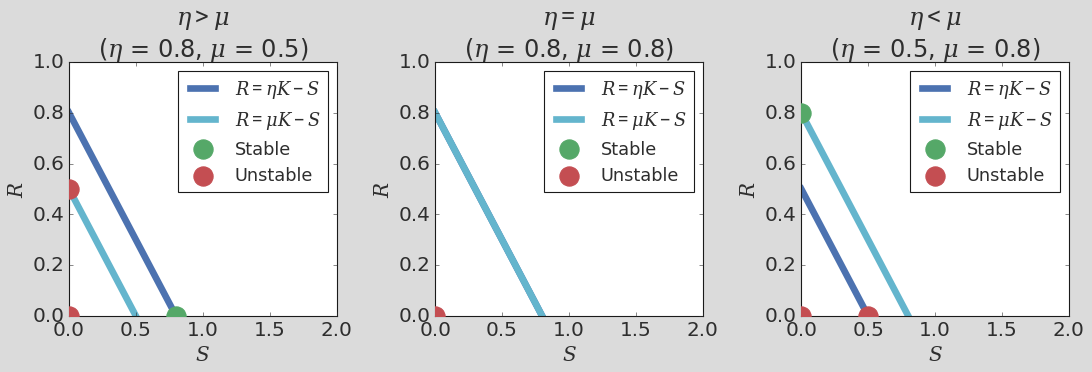

In [19]:
fig, axs = plt.subplots(1,3,figsize=(14,5))

# List points by stability condition, in form [[x1, x2], [y1, y2]] for each region
stable_sets = [[[nss[0].K*nss[0].eta],[0]], [[],[]], [[0],[nss[2].K*nss[2].mu]]]
unstable_sets = [[[0,0],[0,nss[0].K*nss[0].mu]], [[0], [0]], [[0,nss[2].K*nss[2].eta], [0,0]]]
titles = [r'$\eta > \mu$', r'$\eta = \mu$', r'$\eta < \mu$']

for i, ax in enumerate(axs):
    plot_nullclines(ax, nss[i])
    plot_colored_stationary_states(ax, stable_sets[i], unstable_sets[i])
    ax.set_title(titles[i] + f"\n($\eta$ = {nss[i].eta:.1f}, $\mu$ = {nss[i].mu:.1f})")

plt.tight_layout()

### Bifurcation analysis

We may plot these stationary states ($S_{0}$ and $R_{0}$ separately) over $\eta - \mu$ - note the discontinuity in each case at $\eta = \mu$. There is a change in the number of stationary states at this point, and also a change in the stability of stationary states over time point too.

In [20]:
def stable_stationary_S(ns, eta):
    return ns.K * eta if ns.mu < eta else 0

def unstable_stationary_S(ns, eta):
    return ns.K * eta if ns.mu > eta else 0

def stable_stationary_R(ns, mu):
    return ns.K * mu if mu > ns.eta else 0

def unstable_stationary_R(ns, mu):
    return ns.K * mu if mu < ns.eta else 0

Baseline values: $\eta =$ 0.5; $\mu =$ 0.8

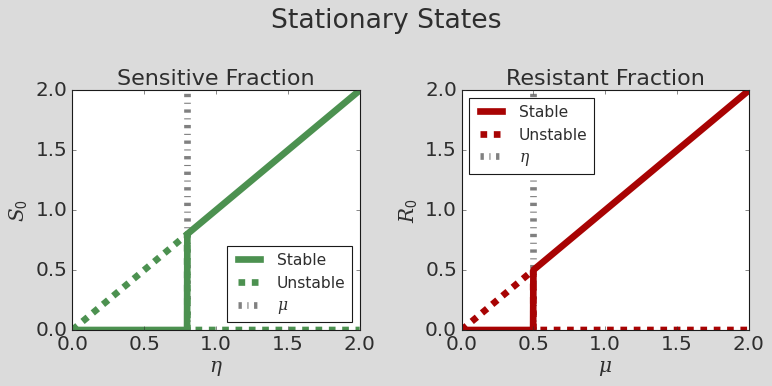

In [21]:
# Stationary States

param_range = np.linspace(0, 2, 1000)
display(Markdown(f"Baseline values: $\eta =$ {ns.eta}; $\mu =$ {ns.mu}"))

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(param_range, [stable_stationary_S(ns, param) for param in param_range], color=colors['Sensitive'], label = 'Stable', linewidth=6, linestyle='-')
axs[1].plot(param_range, [stable_stationary_R(ns, param) for param in param_range], color=colors['Resistant'], label = 'Stable', linewidth=6, linestyle='-')
axs[0].plot(param_range, [unstable_stationary_S(ns, param) for param in param_range], color=colors['Sensitive'], label = 'Unstable', linewidth=6, linestyle='--')
axs[1].plot(param_range, [unstable_stationary_R(ns, param) for param in param_range], color=colors['Resistant'], label = 'Unstable', linewidth=6, linestyle='--')

axs[0].vlines(ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1], x=ns.mu, linewidth=6, linestyle='-.', color = 'gray', label = r'$\mu$', zorder=-1)
axs[1].vlines(ymin=axs[1].get_ylim()[0], ymax=axs[1].get_ylim()[1], x=ns.eta, linewidth=6, linestyle='-.', color = 'gray', label = r'$\eta$', zorder=-1)

axs[0].set_title('Sensitive Fraction', fontsize=20); axs[1].set_title('Resistant Fraction', fontsize=20)
axs[0].set_xlabel(r'$\eta$'); axs[1].set_xlabel(r'$\mu$'); axs[0].set_ylabel(r'$S_{0}$'); axs[1].set_ylabel(r'$R_{0}$')
axs[0].legend(loc=4, fontsize=14); axs[1].legend(loc=2, fontsize=14)
plt.suptitle('Stationary States', fontsize=24); plt.tight_layout()


This is slightly confusing, as the stationary state is defined by two variables - S and R. Furthermore, plotting the bifucation over eta-mu (which is the important variable) hides the fact that each stationary state depends on mu or eta themselves. 

However the main takeaway is that each species has a stable non-zero stationary state when its _'relative fitness'_ is greater than that of the other species. Coexistence is possible when the species have the same _'relative fitness'_.

### Bifurcation in $\delta$ (drug-term)

The prior stability analysis, and assoicated inequalities, assume that $\delta > 0$. However, in previous parameterisations of this model we have taken $\delta < 0$ - i.e. the drug has a net-killing effect (with $d_{D} > 1$). In these parameterisations, the resistant-exclusion stationary state $(S, R) = (0, \mu K)$ is stable (note this also requires non-zero turnover, which we will assume throughout).

This state is stable iff $r_{S} \delta \frac{ d_{R}}{r_{R}} - d_{S} < 0; d_{R} - r_{R} < 0$. The seocnd condition is trivially satisfied for $\mu > 0$, however the first is more complex. As the strength of the drug increases ($d_{D} \to 1$), $\delta \to 0$, and hence $r_{S} \delta \frac{ d_{R}}{r_{R}} - d_{S}$ decreases. Once $\delta <0$, this expression is strictly negative (as all other parameters are strictly positive), and hence this state is always stable.

However, the change in sign of $\delta$ means that the condition $r_{S} \delta \frac{ d_{R}}{r_{R}} - d_{S} < 0$ is now equivalent to $\eta > \mu$ (note the reversal in sign from above). In fact, revising the original definitions of these coefficients ($\eta = \left(1 - \frac{d_{S}}{r_{S}\delta}\right) ; \mu = \left(1 - \frac{d_{R}}{r_{R}}\right)$), we can see that $\eta > 1$ while $\mu < 1$ in this case. <br><br>

We can therefore no longer interpret $\eta$ as the relative fitness of the sensitive state. trivially plotting $\eta$ against $\delta$ we can see this bifurcation clearly, as a result of the $1/x$ divergence.

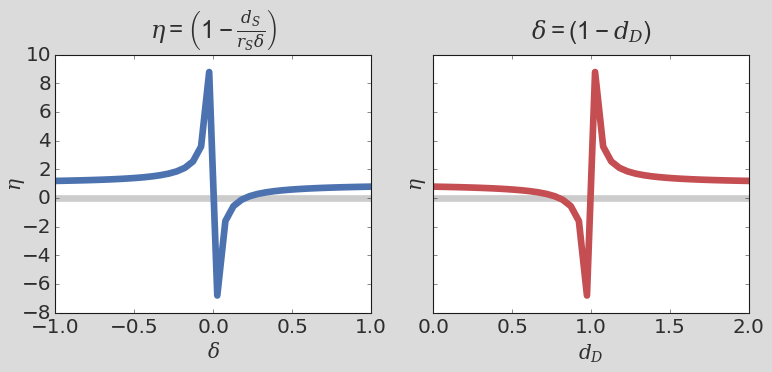

In [22]:
# Plot of eta against delta

dD_vals = np.linspace(0, 2, 40)
delta_vals = [(1-dD) for dD in dD_vals]

fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)
axs[0].plot(delta_vals, [1 - (ns.dS / (ns.rS * delta)) for delta in delta_vals], linewidth = 6, color='b')
axs[1].plot(dD_vals, [1 - (ns.dS / (ns.rS * delta)) for delta in delta_vals], linewidth = 6, color='r')
axs[0].hlines(xmin=min(delta_vals), xmax=max(delta_vals), y=0,
           color='gray',zorder=0, alpha=0.4, linewidth = 6)
axs[1].hlines(xmin=min(dD_vals), xmax=max(dD_vals), y=0,
           color='gray',zorder=0, alpha=0.4, linewidth = 6)

axs[0].set_xlabel("$\delta$"); axs[0].set_ylabel("$\eta$"); axs[0].yaxis.labelpad=-5
axs[1].set_xlabel("$d_{D}$"); axs[1].set_ylabel("$\eta$"); axs[0].yaxis.labelpad=-5

axs[0].set_title(r"$\eta = \left(1 - \frac{d_{S}}{r_{S}\delta}\right)$", pad=15)
axs[1].set_title(r"$\delta = (1 - d_{D})$", pad=15)
plt.tight_layout()

The graph of $\eta$ against $d_{D}$ is perhaps most instructive here. $\eta$ decreases strictly with increasing drug while $d_{D} < 1$, corresponding to this population becoming less fit. At some drug concentration, $\eta$ becomes negative and the sensitive population becomes inherantly unfit (i.e. it would not survive in isolation, without a competing resistant species).

However, at $d_{D} = 1$ a bifurcation occurs, beyond which the drug has a net-killing effect. this fundamentally changes the interpretation of $\eta$, which is no longer a relative fitness term - this is now greater than unity and corresponds to an inherently unfit population. Furthermore in this regime, the $\eta > \mu$ condition on the steady states no longer applies, and the resistant-exclusion state is stable for $\eta < \mu$ (which is guarenteed when $\eta > 1$). <br><br>

Given this change in the meaning of the fundamental parameter, we could redefine this to avoid this bifurcation, at the cost of losing transparency over the stationary states. Instead we will simply redefine the previous cases for stability:

#### 1. $\frac{r_{R}}{d_{R}} < \frac{d_{S}}{r_{S}}\delta$ (previously $\eta > \mu$)

This case primarily occurs for _**non-zero cost and turnover, off treatment**_, where the only stable stationary state is $(S, R) = (\eta K, 0)$.

#### 2. $\frac{r_{R}}{d_{R}} > \frac{d_{S}}{r_{S}}\delta$ (previously $\eta < \mu$)

This case primarily occurs for _**non-zero turnover, on treatment**_, where the only stable stationary state is $(S, R) = (0, \mu K)$.

#### 3. $\frac{r_{R}}{d_{R}} = \frac{d_{S}}{r_{S}}\delta$ (previously $\eta = \mu$)

This special case is primarily assoicated with  _**zero turnover, on or off treatment**_, where the only stable stationary state is $(S, R) = (0, 0)$, with stable oscillations also possible within the $S + R = \mu K$ state (at least for zero turnover). 

When $\delta > 0$ (alternatively $d_{D} < 1$), the new cases coincide with the old ones. In this case, the drug only affect proliferating cells, whereas $d_{D} > 1$ implies that the drug is also killing non-dividing cells as well as dividing cells.

$d_{D} $ must have an upper bound, because the drug is assumed to only affect proliferating cells in previous literature. This means that when the drug term (d_D in our paper) is unity - there is no net proliferation as all daughter cells are being killed at they are formed. Even if we assume that the parent cells are also killed in replication, then a value of 2 means that all cells associated with proliferation would be killed (both parent and daughter) - i.e. a perfectly effective drug. So this must be an upper limit, as any value above this would be equivalent to killing non-proliferating cells (as in a discrete formulation, we have more deaths than the combined sum of all proliferating cells and all daughter cells in each timestep), which contradicts the underlying assumptions of the drug term.

### Phase plot (with trajectories)

Here are the three phase plots (for each region) with trajectories superimposed.

In [23]:
def plot_phase_arrows(ax, ns, point_num = 20, **kwargs):
    S, R = np.meshgrid(np.linspace(*ax.get_xlim(), point_num), np.linspace(*ax.get_ylim(), point_num))
    S_dot = lambda S, R, ns: ns.rS*S * (1 - (S+R) / ns.K) * (1-ns.dD) - ns.dS*S
    R_dot = lambda S, R, ns: ns.rR*R * (1 - (S+R) / ns.K) - ns.dR*R
    ax.quiver(S, R, S_dot(S, R, ns), R_dot(S, R, ns), **kwargs)

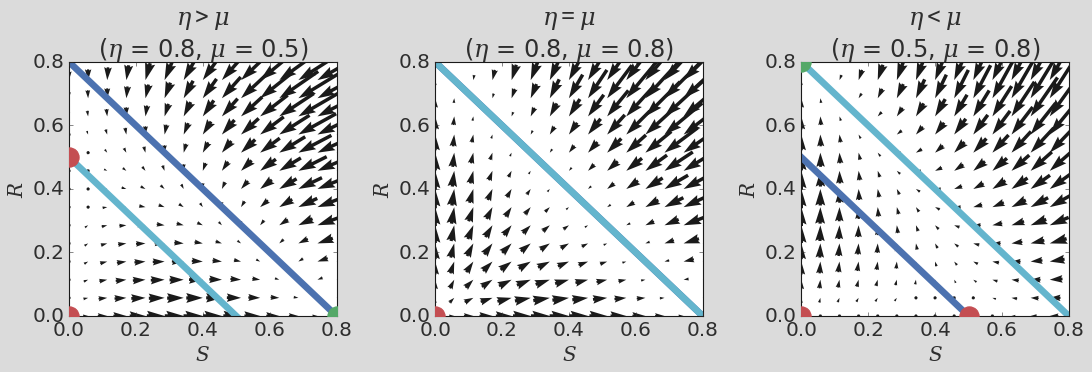

In [24]:
fig, axs = plt.subplots(1,3,figsize=(14,5))

# List points by stability condition, in form [[x1, x2], [y1, y2]] for each region
stable_sets = [[[nss[0].K*nss[0].eta],[0]], [[],[]], [[0],[nss[2].K*nss[2].mu]]]
unstable_sets = [[[0,0],[0,nss[0].K*nss[0].mu]], [[0], [0]], [[0,nss[2].K*nss[2].eta], [0,0]]]
titles = [r'$\eta > \mu$', r'$\eta = \mu$', r'$\eta < \mu$']

for i, ax in enumerate(axs):
    ax.set_xlim(0, 0.8); ax.set_ylim(0, 0.8);
    plot_nullclines(ax, nss[i])
    plot_colored_stationary_states(ax, stable_sets[i], unstable_sets[i])
    plot_phase_arrows(ax, nss[i], point_num=15, scale=0.06, width=0.013, pivot = 'tip')
    ax.set_title(titles[i] + f"\n($\eta$ = {nss[i].eta:.1f}, $\mu$ = {nss[i].mu:.1f})")
    ax.get_legend().remove(); ax.set_xticks(ax.get_xticks()[::2]); ax.set_yticks(ax.get_yticks()[::2])

plt.tight_layout()


### Treatment Regimes

In [25]:
def plot_treatment_trajectory(ax, ax2, ns, at_arg=True, drug_val=1, t_max=5000, **kwargs):
    model = LotkaVolterraModel(method = 'RK45')
    model.SetParams(**vars(ns))

    if at_arg:
        model.Simulate_AT(atThreshold=0.5, intervalLength=30, t_end=t_max, tumourSizeWhenProgressed=np.inf)
        color = colors['AT']
    else:
        model.Simulate([[0, t_max, drug_val]])
        color = colors['CT'] if drug_val > 0 else 'k'

    model.Trim(dt=1)
    # model.resultsDf = model.resultsDf[model.resultsDf['TumourSize'] < model.resultsDf['TumourSize'][0] * 1.2]
    palette = {'TumourSize': color, 'S': colors['Sensitive'], 'R': colors['Resistant']}
    Plot_method(model.resultsDf, ax=ax2, legend=False, colors = palette, **kwargs)

    ax.plot(model.resultsDf['S'], model.resultsDf['R'], linewidth=6, color=color, **kwargs)


In [26]:
for ns in nss:
    ns.n0 = 0.75
    print(ns)

Namespace(n0=0.75, rS=0.027, rR=0.0108, dS=0.0054, dR=0.0054, dD=0, K=1.0, D=0, theta=1, DMax=1.0, S0=0.74925, R0=0.00075, delta=1, eta=0.8, mu=0.5)
Namespace(n0=0.75, rS=0.027, rR=0.027, dS=0.0054, dR=0.0054, dD=0, K=1.0, D=0, theta=1, DMax=1.0, S0=0.74925, R0=0.00075, delta=1, eta=0.8, mu=0.8)
Namespace(n0=0.75, rS=0.027, rR=0.027, dS=0.0054, dR=0.0054, dD=0.6, K=1.0, D=0, theta=1, DMax=1.0, S0=0.74925, R0=0.00075, delta=0.4, eta=0.5, mu=0.8)


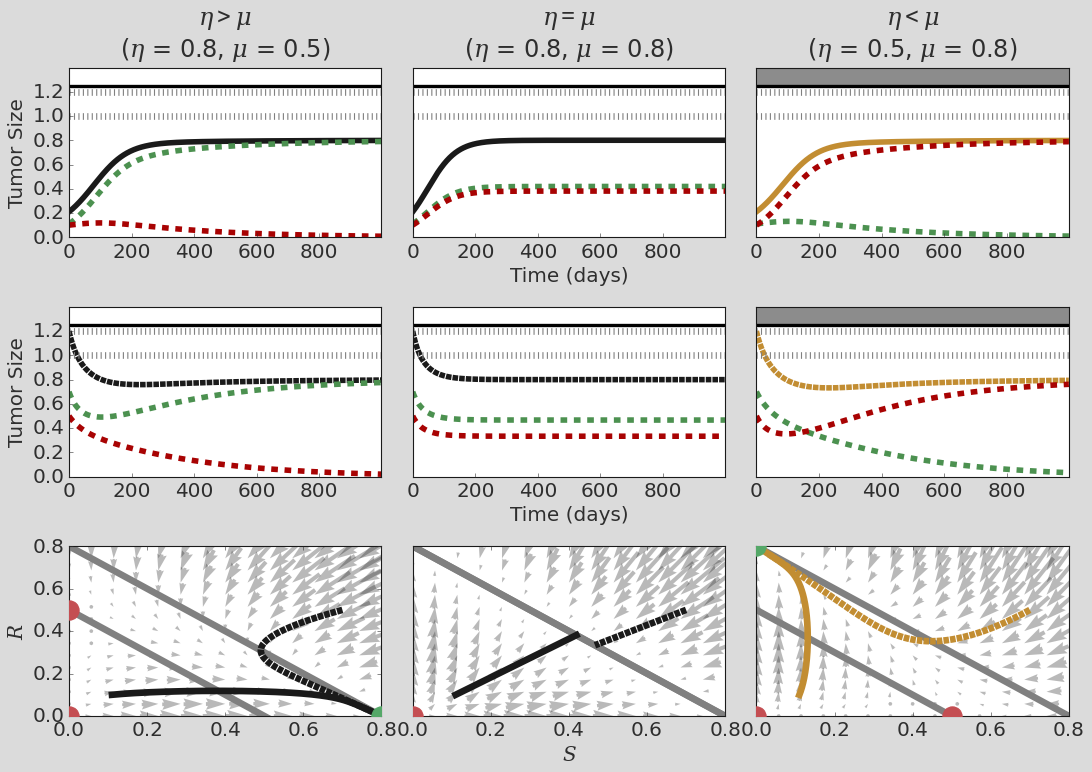

In [27]:
fig, axs = plt.subplots(3,3,figsize=(14,10))

drug_vals = [0, 0, 1]

for i, ax in enumerate(axs[2]):
    ax.set_xlim(0, 0.8); ax.set_ylim(0, 0.8);
    plot_nullclines(ax, nss[i], colors = ['gray', 'gray'])
    plot_colored_stationary_states(ax, stable_sets[i], unstable_sets[i])
    plot_phase_arrows(ax, nss[i], point_num=15, scale=0.06, width=0.013, pivot = 'tip', alpha=0.3)

    nss[i].S0 = 0.11; nss[i].R0 = 0.1
    plot_treatment_trajectory(ax, axs[0][i], nss[i], at_arg=False, drug_val=drug_vals[i], t_max=1000)
    nss[i].S0 = 0.7; nss[i].R0 = 0.5
    plot_treatment_trajectory(ax, axs[1][i], nss[i], at_arg=False, drug_val=drug_vals[i], t_max=1000, linestyle = (0, (5,1)))

    axs[0][i].set_title(titles[i] + f"\n($\eta$ = {nss[i].eta:.1f}, $\mu$ = {nss[i].mu:.1f})", pad = 10)
    ax.get_legend().remove(); ax.set_xticks(ax.get_xticks()[::2]); ax.set_yticks(ax.get_yticks()[::2])
    # mesh_size_change(ax, nss[i], box_num=50, cmap='seismic_r', norm = CenteredNorm(), zorder=0)

    if i > 0:
        ax.set_yticks([]); axs[0][i].set_yticks([]); axs[1][i].set_yticks([]); 

axs[1][1].set_xlabel('Time (days)'); axs[0][1].set_xlabel('Time (days)'); 
axs[0][0].set_ylabel('Tumor Size'); axs[1][0].set_ylabel('Tumor Size'); 
axs[2][1].set_ylabel(''); axs[2][2].set_ylabel(''); 
axs[2][0].set_xlabel(''); axs[2][2].set_xlabel(''); 

fig.tight_layout(); plt.subplots_adjust(wspace=0.1)

We can also plot such trajectories for an adaptive treatment schedule:

In [28]:
ns = Namespace(**odeParamDic); 
ns.delta = 1 - ns.dD; ns.eta = 1 - (ns.dS / (ns.rS * ns.delta)); ns.mu = 1 - (ns.dR / ns.rR)

at_model = LotkaVolterraModel(method='RK45')
at_model.SetParams(**vars(ns))
at_model.Simulate_AT(atThreshold=0.5, intervalLength=30, t_end=5000);
at_model.Trim(dt=1)

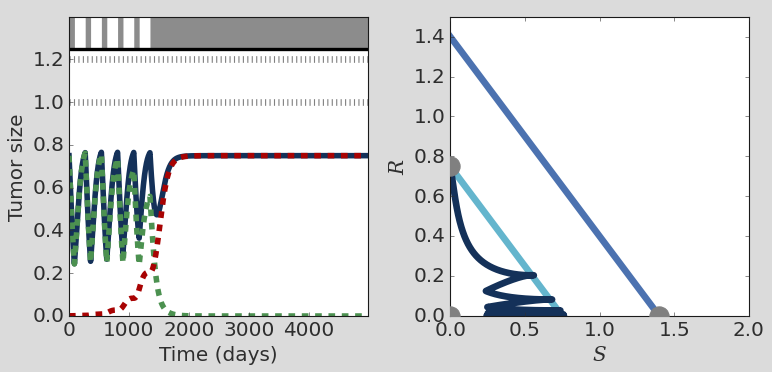

In [29]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

palette = {'TumourSize': colors['AT'], 'S': colors['Sensitive'], 'R': colors['Resistant']}
Plot_method(at_model.resultsDf, ax=axs[0], legend=False, colors = palette)

plot_nullclines(axs[1], ns)
plot_stationary_states(axs[1], ns)
axs[1].plot(at_model.resultsDf['S'], at_model.resultsDf['R'], linewidth=6, color=colors['AT'])

axs[0].set_xlabel('Time (days)'); axs[0].set_ylabel('Tumor size')
axs[1].get_legend().remove(); plt.tight_layout()

### Switching States

For some parameters, is it possible to modulate $\delta$ such that we can first reach the $(S, R) = (\eta K, 0)$ state with minimal/no drug, and then increase drug levels such that $\delta < \frac{d_{S}}{{r_S}}$ to eliminate the tumor. Note that this final null state is fundamentally unstable under this model, however physcially we will not have small perturbations in the population of an eliminated state (and this also doesn't include natural immune response, which is effective against small populations).

In [30]:
odeParamDic_highR = convert_ode_parameters(n0=0.3, rFrac=0.25, cost=0.3, turnover=0.3)

ns = Namespace(**odeParamDic_highR); 
ns.delta = 1 - ns.dD; ns.eta = 1 - (ns.dS / (ns.rS * ns.delta)); ns.mu = 1 - (ns.dR / ns.rR)
threshold_size = 1e-2  # Size at which population can be considered zero

model0 = LotkaVolterraModel(method = 'RK45')
model0.SetParams(**odeParamDic_highR)
model0.Simulate([[0, 1000, 1]]); model0.Trim(dt=1)

model1 = LotkaVolterraModel(method = 'RK45')
model1.SetParams(**odeParamDic_highR)
model1.Simulate([[0, 5000, 0]]); model1.Trim(dt=1)

model1.resultsDf = model1.resultsDf[model1.resultsDf['R'] > threshold_size]
odeParamDic_highR['S0'] = model1.resultsDf['S'].iloc[-1]
odeParamDic_highR['R0'] = 0  # Approximate at zero for sub-threshold population
switch_time = model1.resultsDf['Time'].iloc[-1]

model2 = LotkaVolterraModel(method = 'RK45')
model2.SetParams(**odeParamDic_highR)
model2.Simulate([[0, 1000, 1]]); model2.Trim(dt=1)
model2.resultsDf = model2.resultsDf[model2.resultsDf['S'] > threshold_size]
model2.resultsDf['Time'] += switch_time

full_results = pd.concat([model1.resultsDf, model2.resultsDf])

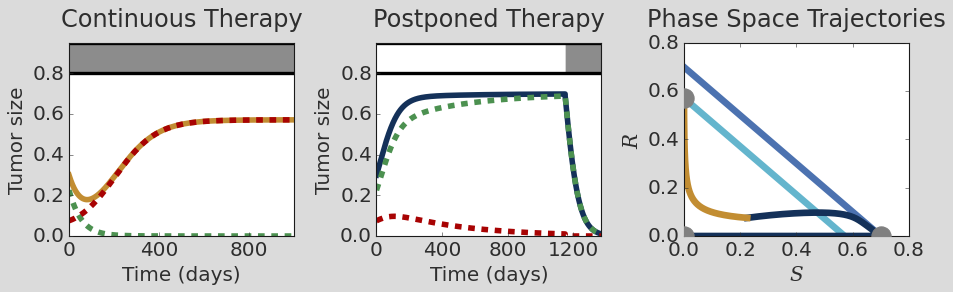

In [31]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
ns.eta = 1 - (ns.dS / (ns.rS))  # Adapt for drug-free stationary state

palette = {'TumourSize': colors['CT'], 'S': colors['Sensitive'], 'R': colors['Resistant']}
Plot_method(model0.resultsDf, ax=axs[0], legend=False, colors = palette)
PlotDrug(model0.resultsDf, ax=axs[0], color='k', currDrugBarPosition = 0.8, drugBarHeight = 0.15)

palette['TumourSize'] = colors['AT']
Plot_method(full_results, ax=axs[1], legend=False, colors = palette)
PlotDrug(full_results, ax=axs[1], color='k', currDrugBarPosition = 0.8, drugBarHeight = 0.15)

plot_nullclines(axs[2], ns)
plot_stationary_states(axs[2], ns)
axs[2].plot(full_results['S'], full_results['R'], linewidth=6, color=colors['AT'])
axs[2].plot(model0.resultsDf['S'], model0.resultsDf['R'], linewidth=6, color=colors['CT'])

axs[0].set_title('Continuous Therapy', pad=15)
axs[1].set_title('Postponed Therapy', pad=15)
axs[2].set_title('Phase Space Trajectories', pad=15)

axs[0].set_xlabel('Time (days)'); axs[0].set_ylabel('Tumor size')
axs[1].set_xlabel('Time (days)'); axs[1].set_ylabel('Tumor size')

axs[0].set_xticks(axs[0].get_xticks()[::2]); axs[0].set_yticks(np.arange(0,1,0.2))
axs[1].set_xticks(axs[1].get_xticks()[::2]); axs[1].set_yticks(np.arange(0,1,0.2))
axs[2].set_xticks(np.arange(0,1,0.2)); axs[2].set_yticks(np.arange(0,1,0.2))
axs[0].set_ylim([0, 0.95]); axs[1].set_ylim([0, 0.95])
axs[2].set_xlim([0, 0.8]); axs[2].set_ylim([0, 0.8])
axs[2].get_legend().remove(); plt.tight_layout()

Under this model, you can only reach a sensitive only state at the stationary state (defined by the carrying capacity of the system). Therefore, while this is theoretically possible, it is likely this would correspond to a **fatal tumor burden sustained for an extended period**, and so extinction pattern is not clinically feasible.

In general, such approaches are impossible with a competition-based model with a shared carrying capacity; where the only way to control resistant cells is through competitive supression. This is because complete supression of the resistant population is only achieved by allowing sensitive cells to completely fill the carrying capacity of the system, corresponding to an intolerable burden.

#### _Notes on a closed loop, for some sequence of $\delta$ values - KG_

Instead, can we attain a pattern of indefinite control by combining on and off cycles to get a closed loop in phase space? Or are there parameter combinations where we can? Or can we prove it is impossible?

_Can I show that trajectories approach the nullclines independent of drug value? Or actually given the crossing, perhaps there is a region there where it might be possible?!_

Would it help to plot phase plane with and without drug simultaneously, for small arrows excluding the larger divergence regions above both nullclines? C.f. kim et al fig 2

In [32]:
# Plot of S_dot + R_dot (i.e time derivative of total tumor size)

def mesh_size_change(ax, ns, box_num = 20, **kwargs):
    S, R = np.meshgrid(np.linspace(*ax.get_xlim(), box_num), np.linspace(*ax.get_ylim(), box_num))
    S_dot = lambda S, R, ns: ns.rS*S * (1 - (S+R) / ns.K) * (1-ns.dD) - ns.dS*S
    R_dot = lambda S, R, ns: ns.rR*R * (1 - (S+R) / ns.K) - ns.dR*R

    ax.pcolormesh(S, R, S_dot(S, R, ns) + R_dot(S, R, ns), shading='gouraud', **kwargs)

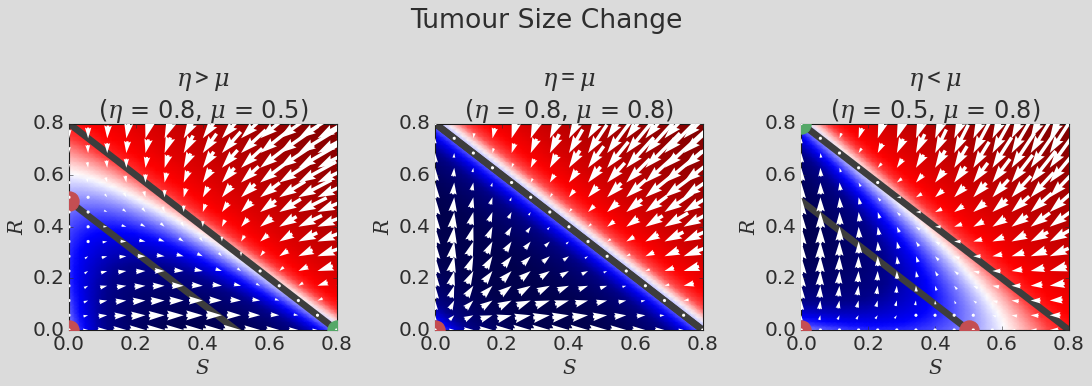

In [33]:
fig, axs = plt.subplots(1,3,figsize=(14,5))
from matplotlib.colors import CenteredNorm, SymLogNorm

# List points by stability condition, in form [[x1, x2], [y1, y2]] for each region
stable_sets = [[[nss[0].K*nss[0].eta],[0]], [[],[]], [[0],[nss[2].K*nss[2].mu]]]
unstable_sets = [[[0,0],[0,nss[0].K*nss[0].mu]], [[0], [0]], [[0,nss[2].K*nss[2].eta], [0,0]]]
titles = [r'$\eta > \mu$', r'$\eta = \mu$', r'$\eta < \mu$']

for i, ax in enumerate(axs):
    ax.set_xlim(0, 0.8); ax.set_ylim(0, 0.8)
    plot_nullclines(ax, nss[i], colors = ['#3d3d3d']*2, alpha=1)
    plot_colored_stationary_states(ax, stable_sets[i], unstable_sets[i])
    plot_phase_arrows(ax, nss[i], point_num=15, scale=0.06, width=0.013, pivot = 'tip', color='w', zorder=10)
    mesh_size_change(ax, nss[i], box_num=50, cmap='seismic_r', norm = SymLogNorm(linthresh=0.002))
    ax.set_title(titles[i] + f"\n($\eta$ = {nss[i].eta:.1f}, $\mu$ = {nss[i].mu:.1f})")
    ax.get_legend().remove(); ax.set_xticks(ax.get_xticks()[::2]); ax.set_yticks(ax.get_yticks()[::2])

fig.suptitle('Tumour Size Change', fontsize=24)
plt.tight_layout()


### Concluding notes

This should be possible. There are two ideas we have - however neither is realistic in the clinic:

#### 1 - Cycling below tolerable burden

Here, we allow growth until a tolerable tumor size. Assuming this is above the R nullcline, we may then apply treatment, and both S and R will now decrease. Once S has decreased sufficiently to drop below the R nullcline, then the resistant population is sufficiently unrestricted by competition to begin regrowth. However this line must then intersect with the original trajectory, and treatment can be removed to cycle indefinitely. However, computing switching times is difficult, as described below.

#### 2 - Cycling about coexistence state

Instead,we may consider cycling about the coexistence state. For any patient parameter set, we may consider a drug level $\delta$ where the sensitive population is sufficiently inhibited to render it equal in fitness to the natively less-fit resistant population, under some intermediate drug dose. If we deviate from the coexistence state, we may make the corresponding change in $\delta$ to return back to it, ultimately cycling around this line.

However, even disregarding the perfect parameter knowledge required here, this also requires a continuous dosing scale to originally achieve, which is not applied in abiraterone therapy, or many other therapeutic agents.

#### Fundamental Limitations

However, we have cannot easily show these cycles exist analytically, as this requires a closed form for the tumor trajectories through phase space - i.e. an analytic solution of this coupled, non-linear ODE system, which is typically intractable. This also makes implementation of these very challenging, as we can only determine the switching times between different drug regimes through simulation, rather than make analytic predictions. Beyond these limitations, we also have not considered the stability of these cycles - these may not be stable for perturbations/inaccuracy in switching times, which would make clinical implementation impossible.

Furthermore, there is a more fundamental issue with cycles in this system. Any closed cycle requires a change in sign of $\dot{S} + \dot{R}$, so that the total tumor size can be conserved over the duration of the cycle. However this is only attained between the two nullclines, and so for tumors on the scale of the system carrying capacity. While adaptive schedules provide a benefit to the patient in the region $N(t) << K$, this only works for much larger tumors that are likely above the tolerable tumor burden (as tumors only transition from exponential to logistic growth around the size that the body can no longer support). This might not be a problem for contained primary tumors (where in crude terms, growth is limited by local constraints, but for widespread metastatic tumors typical of late stage cancers, this only occurs when the entire body cannot support the tumor, and so is typically above the fatal tumor burden, where the body cannot support the tumor and body simultaneously). Therefore, cycles that remain in the region $N(t) \sim K$ for extended periods (as all cycles must with this model) will not be clinically tolerable for a patient.

## Animation

In [34]:
def plot_treatment_snapshot(time, df, ax_time, ax_phase, ns, linewidth=6, tick_sample=1, **kwargs):
    ttp = max(df['Time'])
    df = df.copy()[df['Time'] <= time]
    palette = {'TumourSize': 'k', 'S': colors['Sensitive'], 'R': colors['Resistant']}

    [[[0,0],[0,nss[0].K*nss[0].mu]], [[0], [0]], [[0,nss[2].K*nss[2].eta], [0,0]]]
    # plot_colored_stationary_states(ax, [[nss[2].K*nss[2].eta, 0]], [[0,0],[0,nss[0].K*nss[0].mu]])

    plot_nullclines(ax_phase, ns, colors = ['gray', 'gray'])
    plot_phase_arrows(ax_phase, ns, point_num=15, scale=0.06, width=0.013, pivot='tip', alpha=0.3)
    ax_phase.plot(df['S'], df['R'], linewidth=linewidth, color=palette['TumourSize'], **kwargs)
    ax_phase.get_legend().remove()

    df[list(palette.keys())] = df[list(palette.keys())] / df.TumourSize.iloc[0]  # Normalisation
    Plot_method(df, ax=ax_time, legend=False, colors=palette, linewidth=linewidth, **kwargs)
    ax_time.set_xlim(0, ttp); ax_time.set_ylim(0, 1.4)
    ax_time.set_xticks(ax_time.get_xticks()[::tick_sample])

In [35]:
def format_axes(ax_time, ax_phase, title):
    ax_time.set_title(title, fontfamily='monospace')
    ax_phase.set_title('Phase Space', fontfamily='monospace')
    ax_phase.set_xlim(0, 1)
    ax_phase.set_ylim(0, 1)

    ax_time.set_xlabel('Time (days)', fontfamily='monospace')
    ax_time.set_ylabel('Tumor size', fontfamily='monospace')
    ax_phase.set_xlabel('Sensitive population', fontfamily='monospace')
    ax_phase.set_ylabel('Resistant population', fontfamily='monospace')

    for i, axis in enumerate([ax_time, ax_phase]):
        for j, (getter, setter) in enumerate(zip([axis.get_xticks, axis.get_yticks], 
                                  [axis.set_xticklabels, axis.set_yticklabels])):
            if i == 0 and j == 0:
                labels = [f'{label:.0f}' for label in getter()]
            else:
                labels = [f'{label:.1f}' for label in getter()]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                setter(labels=labels, fontfamily='monospace')

In [36]:
def general_update(frame, ax_time, ax_phase, time_points, model, ns, **kwargs):
    ax_time.clear(); ax_phase.clear()
    plot_treatment_snapshot(time_points[frame], model.resultsDf, ax_time, ax_phase, ns, **kwargs)

    time_str = f'{time_points[frame]:.0f}'
    title = f'Time: {" "*(3-len(time_str))}{time_str} days'
    format_axes(ax_time, ax_phase, title)
    fig.tight_layout(pad=1.5)

In [37]:
def plot_background(df, ax_time, ax_phase, ns, linewidth=6, tick_sample=1, **kwargs):
    ttp = max(df['Time'])
    palette = {'TumourSize': 'k', 'S': colors['Sensitive'], 'R': colors['Resistant']}

    [[[0,0],[0,nss[0].K*nss[0].mu]], [[0], [0]], [[0,nss[2].K*nss[2].eta], [0,0]]]
    # plot_colored_stationary_states(ax, [[nss[2].K*nss[2].eta, 0]], [[0,0],[0,nss[0].K*nss[0].mu]])

    plot_nullclines(ax_phase, ns, colors = ['gray', 'gray'])
    plot_phase_arrows(ax_phase, ns, point_num=15, scale=0.06, width=0.013, pivot='tip', alpha=0.3)
    ax_phase.get_legend().remove()

    ax_time.set_xlim(0, ttp); ax_time.set_ylim(0, 1.4)
    new_ticks = ax_time.get_xticks()[::tick_sample]
    ax_time.set_xticks(new_ticks, labels=[f'{label:.0f}' for label in new_ticks])

In [38]:
def faster_update(frame, ax_time, ax_phase, tumor_lines, drug_lines, phase_line, time_points, model, ns, linewidth=6, **kwargs):
    palette = {'TumourSize': 'k', 'S': colors['Sensitive'], 'R': colors['Resistant']}
    df = model.resultsDf.copy()[model.resultsDf['Time'] <= time_points[frame]]
    df[list(palette.keys())] = df[list(palette.keys())] / df.TumourSize.iloc[0]  # Normalisation
    # Plot_method(df, ax=ax_time, legend=False, colors=palette, linewidth=linewidth, **kwargs)

    phase_line.set_data(df['S'], df['R'])

    for line, name in zip(tumor_lines, ['TumourSize', 'S', 'R']):
        line.set_data(df['Time'], df[name])

    ax_time.collections.clear()
    drugConcentrationVec = CalcDrug(df) * 0.2 + 1.2
    ax_time.fill_between(x=df['Time'], y1=1.2, y2=drugConcentrationVec, linewidth=0.0,
                         alpha=0.5, step="post", label="Drug Concentration", color='k', **kwargs)
    drug_lines[1].set_data([0, max(df['Time'])], [1.2, 1.2]); 
    drug_lines[2].set_data([0, max(df['Time'])], [1.4, 1.4])

    time_str = f'{time_points[frame]:.0f}'
    title = f'Time: {" "*(3-len(time_str))}{time_str} days'
    ax_time.set_title(title, fontfamily='monospace')    

In [39]:
# Generate patient params

aniParamDic = convert_ode_parameters(n0=0.6, rFrac=0.004, cost=0., turnover=0.25); 
aniParamDic = convert_ode_parameters(n0=1.0, rFrac=0.004, cost=0., turnover=0.25); 
aniParamDic['K'] = 1.75

ns = Namespace(**aniParamDic); 
ns.delta = 1 - ns.dD; ns.eta = 1 - (ns.dS / (ns.rS * ns.delta)); ns.mu = 1 - (ns.dR / ns.rR)

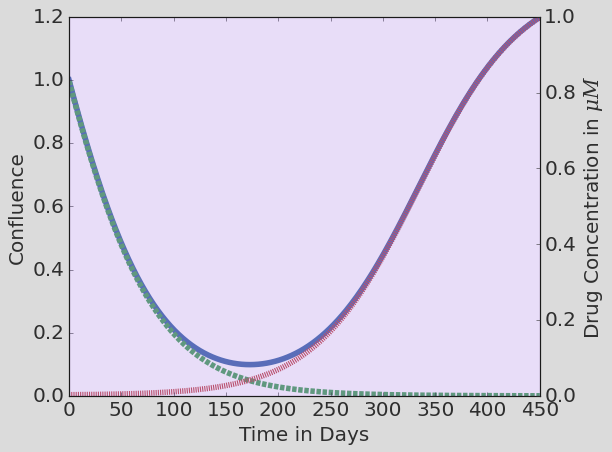

In [40]:
warnings.filterwarnings("ignore", category=FutureWarning)

# FILEPATH: /Users/80024651/Documents/Moffitt/ML_driven_tx/analytics/stationary_states.ipynb
# Continuous Therapy
ct_model = LotkaVolterraModel(method='RK45')
ct_model.SetParams(**vars(ns))
ct_model.Simulate([[0, 3000, 1]])
ct_model.Trim(dt=1)
ct_model.resultsDf = ct_model.resultsDf[ct_model.resultsDf['TumourSize'] < ct_model.resultsDf['TumourSize'][0] * 1.2]
ct_model.Plot(plotPops=True)
plt.gcf().get_axes()[0].legend().remove()



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


MovieWriter ffmpeg unavailable; using Pillow instead.


Note: you may need to restart the kernel to use updated packages.


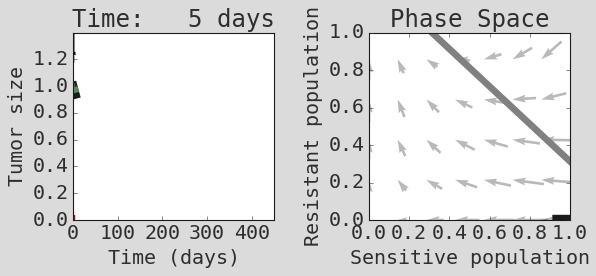

In [62]:
from IPython import display

# Install ffmpeg package

time_points = ct_model.resultsDf['Time'].values[5::5]
fig, (ax_time, ax_phase) = plt.subplots(1, 2, figsize=(8, 4))

update = lambda frame: general_update(frame, ax_time, ax_phase, time_points, ct_model, ns, linewidth=8, tick_sample=2)  
ani = animation.FuncAnimation(fig, update, frames=len(time_points), interval=20)

%pip install ffmpeg
ani.save('../gifs/continuous_therapy.gif', writer='ffmpeg', dpi=100)




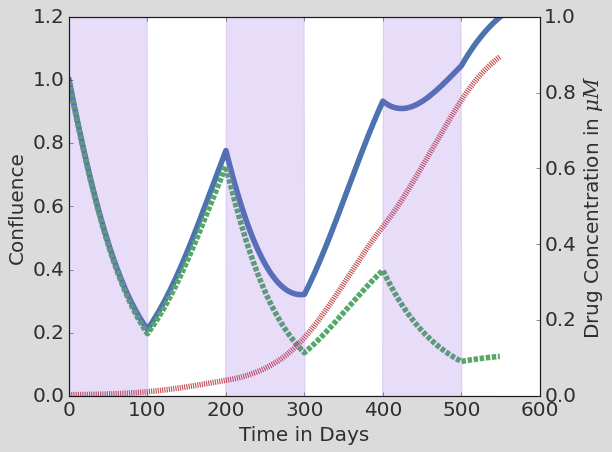

In [50]:
# Metronomic Therapy
interval = 100; schedule = [[interval*t, interval*(t+1), (t+1)%2] for t in range(20)]
mt_model = LotkaVolterraModel(method = 'RK45')
mt_model.SetParams(**vars(ns))
mt_model.Simulate(schedule)
mt_model.Trim(dt=1)
mt_model.resultsDf = mt_model.resultsDf[mt_model.resultsDf['TumourSize'] < mt_model.resultsDf['TumourSize'][0] * 1.2]
mt_model.Plot(plotPops=True)
plt.gcf().get_axes()[0].legend().remove()

MovieWriter ffmpeg unavailable; using Pillow instead.


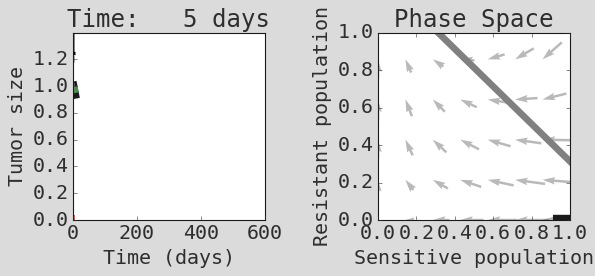

In [63]:
from IPython import display

time_points = mt_model.resultsDf['Time'].values[5::5]
fig, (ax_time, ax_phase) = plt.subplots(1, 2, figsize=(8, 4))

update = lambda frame: general_update(frame, ax_time, ax_phase, time_points, mt_model, ns, linewidth=8, tick_sample=2)  
ani = animation.FuncAnimation(fig, update, frames=len(time_points), interval=50)

ani.save('../gifs/metronomic_therapy.gif', writer='ffmpeg', dpi=100, codec='libx264')

# display.HTML(ani.to_jshtml())
# HTML(ani.to_jshtml())

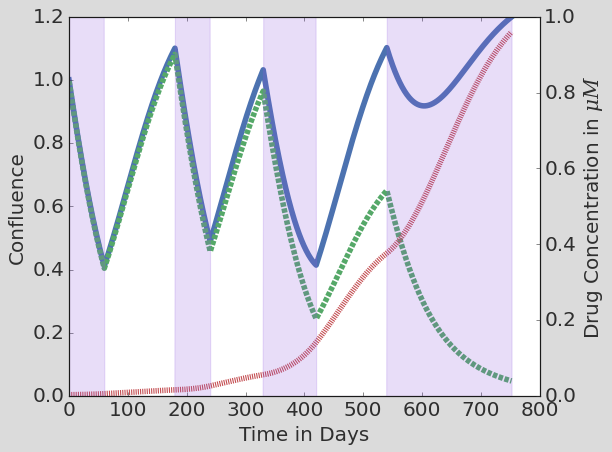

In [52]:
# Adaptive Therapy
at_model = LotkaVolterraModel(method = 'RK45')
at_model.SetParams(**vars(ns))
at_model.Simulate_AT(atThreshold=0.5, intervalLength=30, t_end=2000);
at_model.Trim(dt=1); at_model.resultsDf = at_model.resultsDf[at_model.resultsDf['TumourSize'] < at_model.resultsDf['TumourSize'][0] * 1.2]
at_model.Plot(plotPops=True)
plt.gcf().get_axes()[0].legend().remove()

MovieWriter ffmpeg unavailable; using Pillow instead.


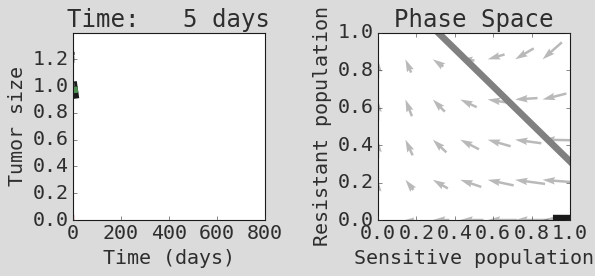

In [61]:
from IPython import display

time_points = at_model.resultsDf['Time'].values[5::5]
fig, (ax_time, ax_phase) = plt.subplots(1, 2, figsize=(8, 4))

update = lambda frame: general_update(frame, ax_time, ax_phase, time_points, at_model, ns, linewidth=8, tick_sample=2)  
ani = animation.FuncAnimation(fig, update, frames=len(time_points), interval=50)

ani.save('../gifs/adaptive_therapy.gif', writer='ffmpeg', dpi=100)

# display.HTML(ani.to_jshtml())
# HTML(ani.to_jshtml())